In [2]:
!pip install lambeq
!pip install jax
!pip install jaxlib

# clone GitHub repository
!git clone https://github.com/CQCL/lambeq.git

/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
fatal: destination path 'lambeq' already exists and is not an empty directory.


In [3]:
import torch
import numpy as np
from lambeq import BobcatParser, Dataset, QuantumTrainer, SPSAOptimizer
from discopy import grammar
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel
from discopy.drawing import equation

In [4]:
BATCH_SIZE = 30
EPOCHS = 120
LEARNING_RATE = 3e-2
SEED = 0

In [5]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [6]:
train_labels, train_data = read_data('lambeq/docs/examples/datasets/mc_train_data.txt')
val_labels, val_data = read_data('lambeq/docs/examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('lambeq/docs/examples/datasets/mc_test_data.txt')


# TASK 2: GET AN OVERVIEW OF THE DATASET
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

In [7]:
parser = BobcatParser(verbose='text')

# Parse sentences from the three datasets to  diagrams
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [11]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

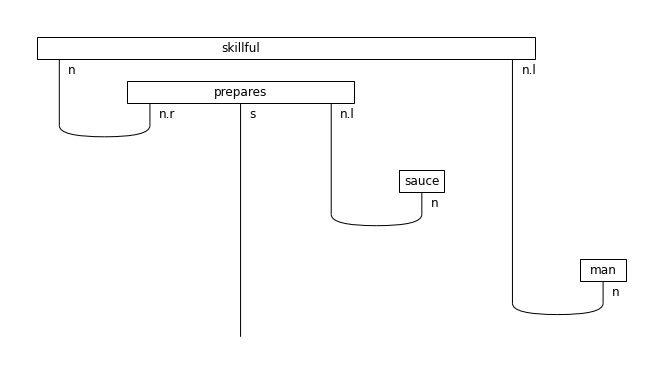

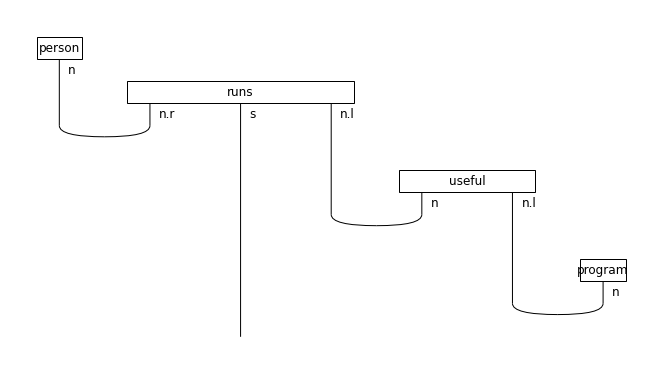

In [12]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

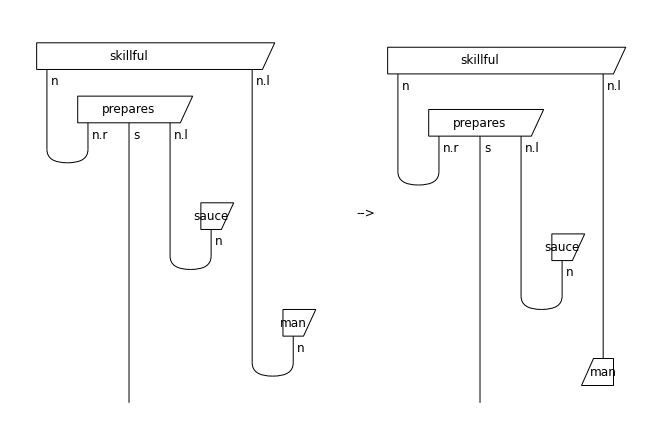

In [13]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits = [ansatz(remove_cups(diagram)) for diagram in test_diagrams]

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

In [14]:
all_circuits = train_circuits + val_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# Define evaluation metric
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [15]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [ ]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

In [48]:
import random

sentence 1:woman prepares meal .
sentence 2:woman prepares tasty dinner .

 they belong to the same category


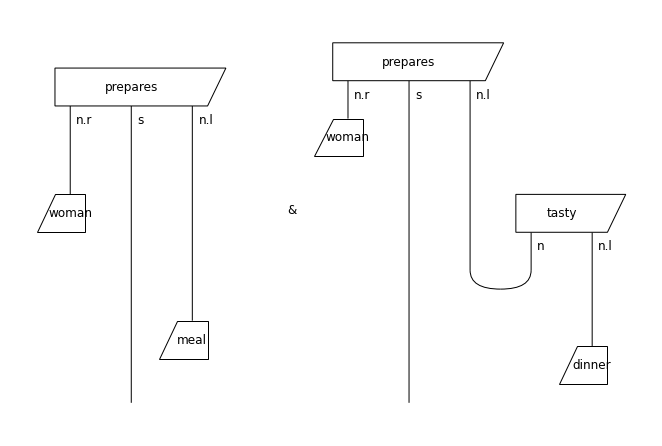

In [102]:
# choosing two sentences at random
sentence_index = random.sample(range(0, 30),2)
x=sentence_index[0]
y=sentence_index[1]


# comparison with two different sentences
print('sentence 1:' + test_data[x] + '\n' + 'sentence 2:' + test_data[y])
if test_labels[x]==test_labels[y]:
    
    print('\n they belong to the same category')
else:
    print('\n they belong to different categories')

equation(remove_cups(test_diagrams[x]), remove_cups(test_diagrams[y]), symbol='&', figsize=(9, 6), asymmetry=0.3, fontsize=12)